# Linear Regression

This notebook demonstrates how linear regression is used to model data and predict the values of novel samples.

We start with a simple dataset generated from a linear function $y = mx + b$. If we generate values of $x$ linearly, the resulting dataset will be too clean and uninteresting to model. We will simulate some variance here by adding some Gaussian noise.

In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%matplotlib widget

In [2]:
# Generate a bias term and slope between -1 and 1
b = (np.random.rand() * 2) - 1
m = (np.random.rand() * 2) - 1
noise_weight = 0.1

num_samples = 100
x = np.array(list(range(num_samples)), dtype=np.float32)
x = x / num_samples

y = m * x + b + (noise_weight * np.random.randn(num_samples))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
# ax.axline([0, b], slope=m, c='r')
ax.set_title("Original Data");

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [4]:
m_est = -0.7
b_est = 0

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
ax.axline([0, b_est], slope=m_est, c='r')
ax.set_title("Manually Tuned Model");

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The generated data is plotted above along with the underlying true function that was used to generate it. If we already know what the true function is, our job is done. Suppose that we only have the data points (in blue). How do we go about modelling it? It is reasonable to first visualize the data and observe that it does follow a linear pattern. Thus, a linear model would be a decent model to choose.

If the data followed a curve, we may decide to fit a polynomial. We will look at an example of that later on. For now, let's formalize all of the information that we have.

- $(\mathbf{x}, \mathbf{y})$ - Data points from the original dataset. Generally, $\mathbf{x}$ is a vector of features and $\mathbf{y}$ is the target vector. In our simple dataset above, these are both scalar values.
- $\mathbf{w} = (w_0, w_1)$ - Our model parameters. Comparing to the equation $y = mx + b$, $w_0$ is our bias term and $w_1$ is our slope parameter.

## Making Predictions

Given $\mathbf{w}$, we can make a prediction for a new data sample $\mathbf{x} = x_1$.

$$
h(\mathbf{x}; \mathbf{w}) = w_0 + w_1 x_1
$$

Note that the bias term is always added to the result. We can simplify this into a more general form by appending a constant 1 (s.t. $x_0 = 1$) to each of our samples such that $\mathbf{x} = (1, x_1, ..., x_d)$. Then, the general linear model becomes

$$
h(\mathbf{x}; \mathbf{w}) = \sum_{i=0}^{d} w_i x_i = \mathbf{w}^T \mathbf{x}.
$$

If our data happened to have more than 1 feature, it would be easy enough to model it appropriately using this notation.

## Determining Fitness

If we really wanted to, we could fit our model by plotting it and manually adjusting the weights until our model looked acceptable by some qualitative standard. Fortunately we won't be doing that. Instead, we will use a quantitative measurement that provides a metric of how well our current parameters fit the data.

For this, we use a **cost function** or **loss function**. The most common one to use for this type of model is the least-squares function:

$$
J(\mathbf{w}) = \frac{1}{2}\sum_{i=1}^{n}(h(\mathbf{x}_{i};\mathbf{w}) - \mathbf{y}_{i})^2.
$$

Let's jump back into the code for a minute and see this function in action.

In [5]:
def lst_sq(predictions, target):
    return 0.5 * np.sum((predictions - target)**2)

# Create our parameters and append the bias terms to each data sample in the original dataset.
w = np.random.uniform(-1, 1, size=(2,))
data = np.hstack((np.ones((x.shape[0], 1)), x[:, None]))

error = lst_sq(data @ w, y)
print("Error =", error)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
ax.axline([0, w[0]], slope=w[1], c='r')
ax.set_title("Random Model Parameters");

Error = 18.831976820990146


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Stochastic Gradient Descent

Depending on the random initialization of parameters, our error varies greatly. We can observe that no matter what the chose parameters are, there is no possible way we can achieve an error of 0. The best we can do is minimize this error:

$$
\min J(\mathbf{w})
$$

For this, we rely on stochastic gradient descent. The basic idea is as follows:
1. Begin with an initial guess for $\mathbf{w}$
2. Compare the prediction for sample $\mathbf{x}_{i}$ with its target $\mathbf{y}_{i}$.
3. Update $\mathbf{w}$ based on the comparison in part 2.
4. Repeat steps 2 and 3 on the dataset until the loss has converged.

Steps 1, 3, and 4 are easy enough. What about step 2? How can we possibly know how to modify $\mathbf{w}$ such that $J(\mathbf{w})$ will decrease? By computing the gradient $\frac{d}{d\mathbf{w}}J(\mathbf{w})$! How will we know when we have arrived at a minima? When $\nabla J(\mathbf{w}) = 0$.

\begin{align*}
\frac{d}{d\mathbf{w}}J(\mathbf{w}) &= \frac{d}{d\mathbf{w}}\frac{1}{2}(h(\mathbf{x}_{i};\mathbf{w}) - \mathbf{y}_{i})^2\\
&= 2 \cdot \frac{1}{2}(h(\mathbf{x}_{i};\mathbf{w}) - \mathbf{y}_{i}) \cdot \frac{d}{d\mathbf{w}} (h(\mathbf{x}_{i};\mathbf{w}) - \mathbf{y}_{i})\\
&= (h(\mathbf{x}_{i};\mathbf{w}) - \mathbf{y}_{i}) \cdot \frac{d}{d\mathbf{w}} (\mathbf{w}^T \mathbf{x}_{i} - \mathbf{y}_{i})\\
&= (h(\mathbf{x}_{i};\mathbf{w}) - \mathbf{y}_{i}) \mathbf{x}_{i}
\end{align*}

The gradient represents the direction of greatest change for a function evaluated With this gradient, we can use an update rule to modify the previous parameter vector $\mathbf{w}$.

$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha \sum_{i=1}^{n} (h(\mathbf{x}_{i};\mathbf{w}_{t}) - \mathbf{y}_{i}) \mathbf{x}_{i}
$$

Here, $\alpha$ is an update hyperparameter that allows us to control how big or small of a step our weights can take with each update. In general, a smaller value will be more likely to get stuck in local minima. However, too large of a value may never converge to any minima.

For problems like linear regression and logistic regression, we only have a single minima. So, that's a problem for a different day. For now, let's implement sequential learning.

In [83]:
data = np.array([
    [1, 0.2],
    [1, 0.3],
    [1, 0.4],
    [1, 0.5],
    [1, 0.6],
    #[1, 0.9]
])
x = np.array([
    0.2, 0.3, 0.4, 0.5, 0.6#, 0.9
])
y = np.array([
    0.2, 0.3, 0.4, 0.5, 0.6#, 0.4
])

In [84]:
reg = LinearRegression().fit(data, y)
b = reg.intercept_
m = reg.coef_
print(m)

y_hat = reg.predict(data)

# Visualize the new solution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
ax.axline([0, b], slope=m[1], c='b')
for i in range(x.shape[0]):
    ax.plot([x[i], x[i]], [y[i], y_hat[i]], c='r', linewidth=0.5)

[0. 1.]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [62]:
def sgd_step(weights, predictions, target, data, alpha=0.001):
    diff = predictions - target
    update = diff @ data
    w_new = w - alpha * update
    
    return w_new

# We already have our initial guess from above.
# Compute the model's current predictions and run a single step of SGD.
y_hat = data @ w
error = lst_sq(y_hat, y)
print("Error =", error)

# Next, we update the weights based on the loss and data
for i in range(100):
    w = sgd_step(w, y_hat, y, data)

# Recompute the new  y-values for visualization
y_hat = data @ w

# Visualize the new solution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
ax.axline([0, w[0]], slope=w[1], c='b')
ax.axline([0, b], slope=m, c='g')
for i in range(5):
    ax.plot([x[i], x[i]], [y[i], y_hat[i]], c='r', linewidth=0.5)

Error = 0.013231189670529026


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Fitting a Curve

What if our data does not follow a linear model? Perhaps it follows some pattern that curves.

<IPython.core.display.Javascript object>


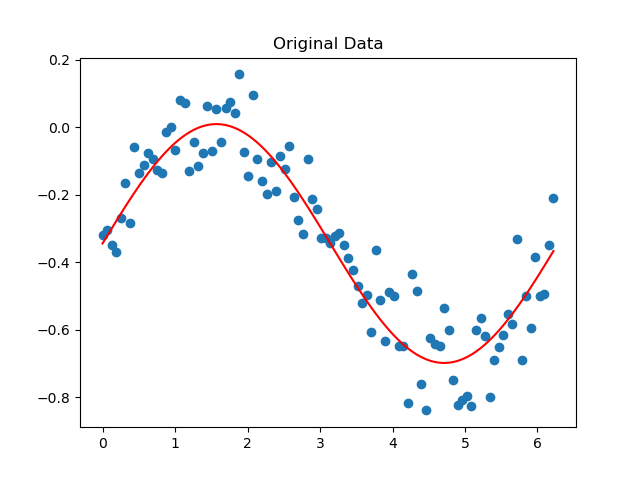

In [31]:
# Generate a bias term and slope between -1 and 1
b = (np.random.rand() * 2) - 1
m = (np.random.rand() * 2) - 1
noise_weight = 0.1

num_samples = 100
x = np.array(list(range(num_samples)), dtype=np.float32)
x = x / num_samples * 2 * math.pi

y = m * np.sin(x) + b + (noise_weight * np.random.randn(num_samples))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
ax.plot(x, m * np.sin(x) + b, c='r')
ax.set_title("Original Data");

# Linear Basis Function Models

Now we need to model a nonlinear function, but the model we chose before is limited by the fact that it is linear. Let's see how well our previous model can fit this data. Since we haven't yet, let's solve it using the normal equations.

Error = 1.5376786782605727


<IPython.core.display.Javascript object>


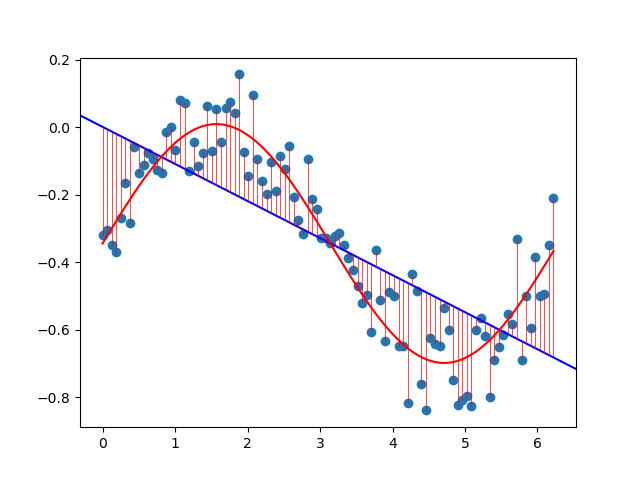

In [42]:
data = np.hstack((np.ones((x.shape[0], 1)), x[:, None]))
w = np.linalg.inv(data.T @ data) @ (data.T @ y)

# Recompute the new  y-values for visualization
y_hat = data @ w
error = lst_sq(y_hat, y)
print("Error =", error)

# Visualize the new solution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
ax.axline([0, w[0]], slope=w[1], c='b')
ax.plot(x, m * np.sin(x) + b, c='r')
for i in range(num_samples):
    ax.plot([x[i], x[i]], [y[i], y_hat[i]], c='r', linewidth=0.5)

The approach of linear basis function models uses nonlinear functions to transform the original features. The most obvious choice of functions to use the class of polynomial functions. Our model won't look that much different:

$$
h(\mathbf{x}; \mathbf{w}) = \sum_{i=0}^{d} w_i \phi_i(\mathbf{x}).
$$

Let's start by using a second-order polynomial: $\phi_1(\mathbf{x}) = x_1$ and $\phi_2(\mathbf{x}) = x_1^2$. Note that $\phi_0(\mathbf{x}) = 1$ to preserve the bias term. In order to solve this using normal equations, our design matrix needs to change to accommodate the basis functions:

\begin{equation*}
\mathbf{X} =
\begin{bmatrix}
1 & \phi_1(\mathbf{x}_1) & \phi_2(\mathbf{x}_1)\\
\vdots & \vdots & \vdots\\
1 & \phi_1(\mathbf{x}_n) & \phi_2(\mathbf{x}_n)
\end{bmatrix}
\end{equation*}

Let's give it a shot!

Error = 1.5288419518129213


<IPython.core.display.Javascript object>


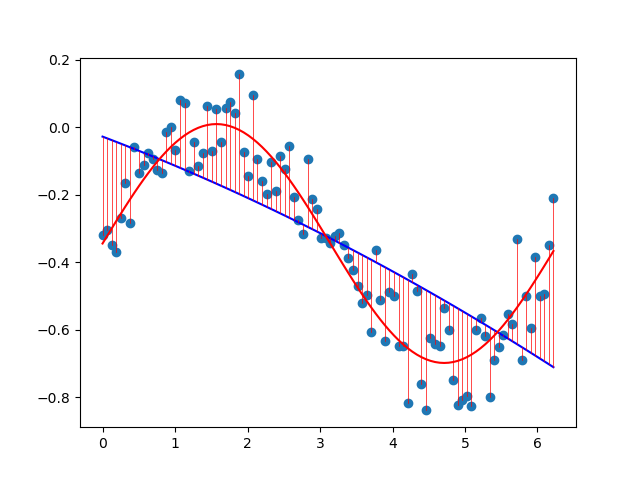

In [44]:
data = np.hstack((np.ones((x.shape[0], 1)), x[:, None], x[:, None]**2))
w = np.linalg.inv(data.T @ data) @ (data.T @ y)

# Recompute the new  y-values for visualization
y_hat = data @ w
error = lst_sq(y_hat, y)
print("Error =", error)

# Visualize the new solution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
ax.plot(x, y_hat, c='b')
ax.plot(x, m * np.sin(x) + b, c='r')
for i in range(num_samples):
    ax.plot([x[i], x[i]], [y[i], y_hat[i]], c='r', linewidth=0.5)

The error has only slightly improved. We can see that the model can now attempt to fit a curve, but our data clearly requires more degrees of freedom. Let's scale up to a third-degree polynomial.

Error = 0.38471119608424675


<IPython.core.display.Javascript object>


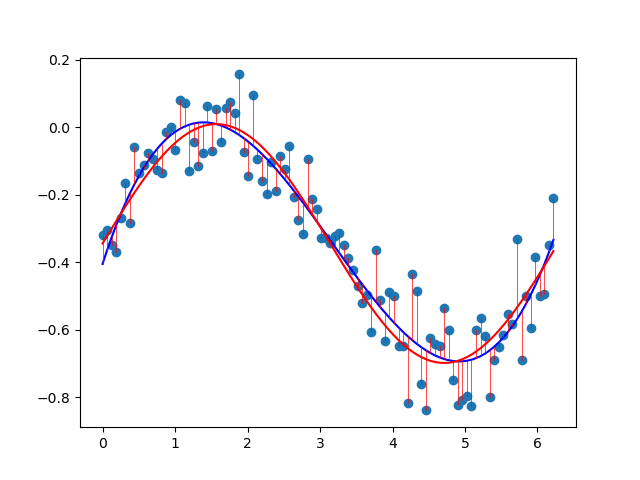

In [45]:
data = np.hstack((np.ones((x.shape[0], 1)), x[:, None], x[:, None]**2, x[:, None]**3))
w = np.linalg.inv(data.T @ data) @ (data.T @ y)

# Recompute the new  y-values for visualization
y_hat = data @ w
error = lst_sq(y_hat, y)
print("Error =", error)

# Visualize the new solution
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
ax.plot(x, y_hat, c='b')
ax.plot(x, m * np.sin(x) + b, c='r')
for i in range(num_samples):
    ax.plot([x[i], x[i]], [y[i], y_hat[i]], c='r', linewidth=0.5)